In [1]:
import os, time

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk

import sys
sys.path.append('../')
from datasets.hecktor_petct_dataset import HECKTORPETCTDataset
from datautils.preprocessing import Preprocessor
from datautils.patch_sampling import PatchSampler3D, PatchQueue, get_num_valid_patches
from datautils.patch_aggregation import PatchAggregator3D
from datautils.visualization import NdimageVisualizer

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [2]:
data_dir = "/home/chinmay/Datasets/HECKTOR/hecktor_train/crS_rs113_hecktor_nii"
patient_id_filepath = "../hecktor_meta/patient_IDs_train.txt"

preprocessor = Preprocessor()

viz = NdimageVisualizer()

In [3]:
sample_idx = 0

PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                     patient_id_filepath, 
                                     mode='training', 
                                     preprocessor=preprocessor,
                                     input_representation='separate-volumes', 
                                     augment_data=False)

patient_dict = PET_CT_dataset[sample_idx]

# For visualization purpose
PET_np = patient_dict['PET'].squeeze().permute(2,1,0).numpy()
CT_np = patient_dict['CT'].squeeze().permute(2,1,0).numpy()
GTV_labelmap_np = patient_dict['GTV-labelmap'].squeeze().permute(2,1,0).numpy()

torch.Size([1, 48, 144, 144])
tensor(0.0014)
tensor(20.)


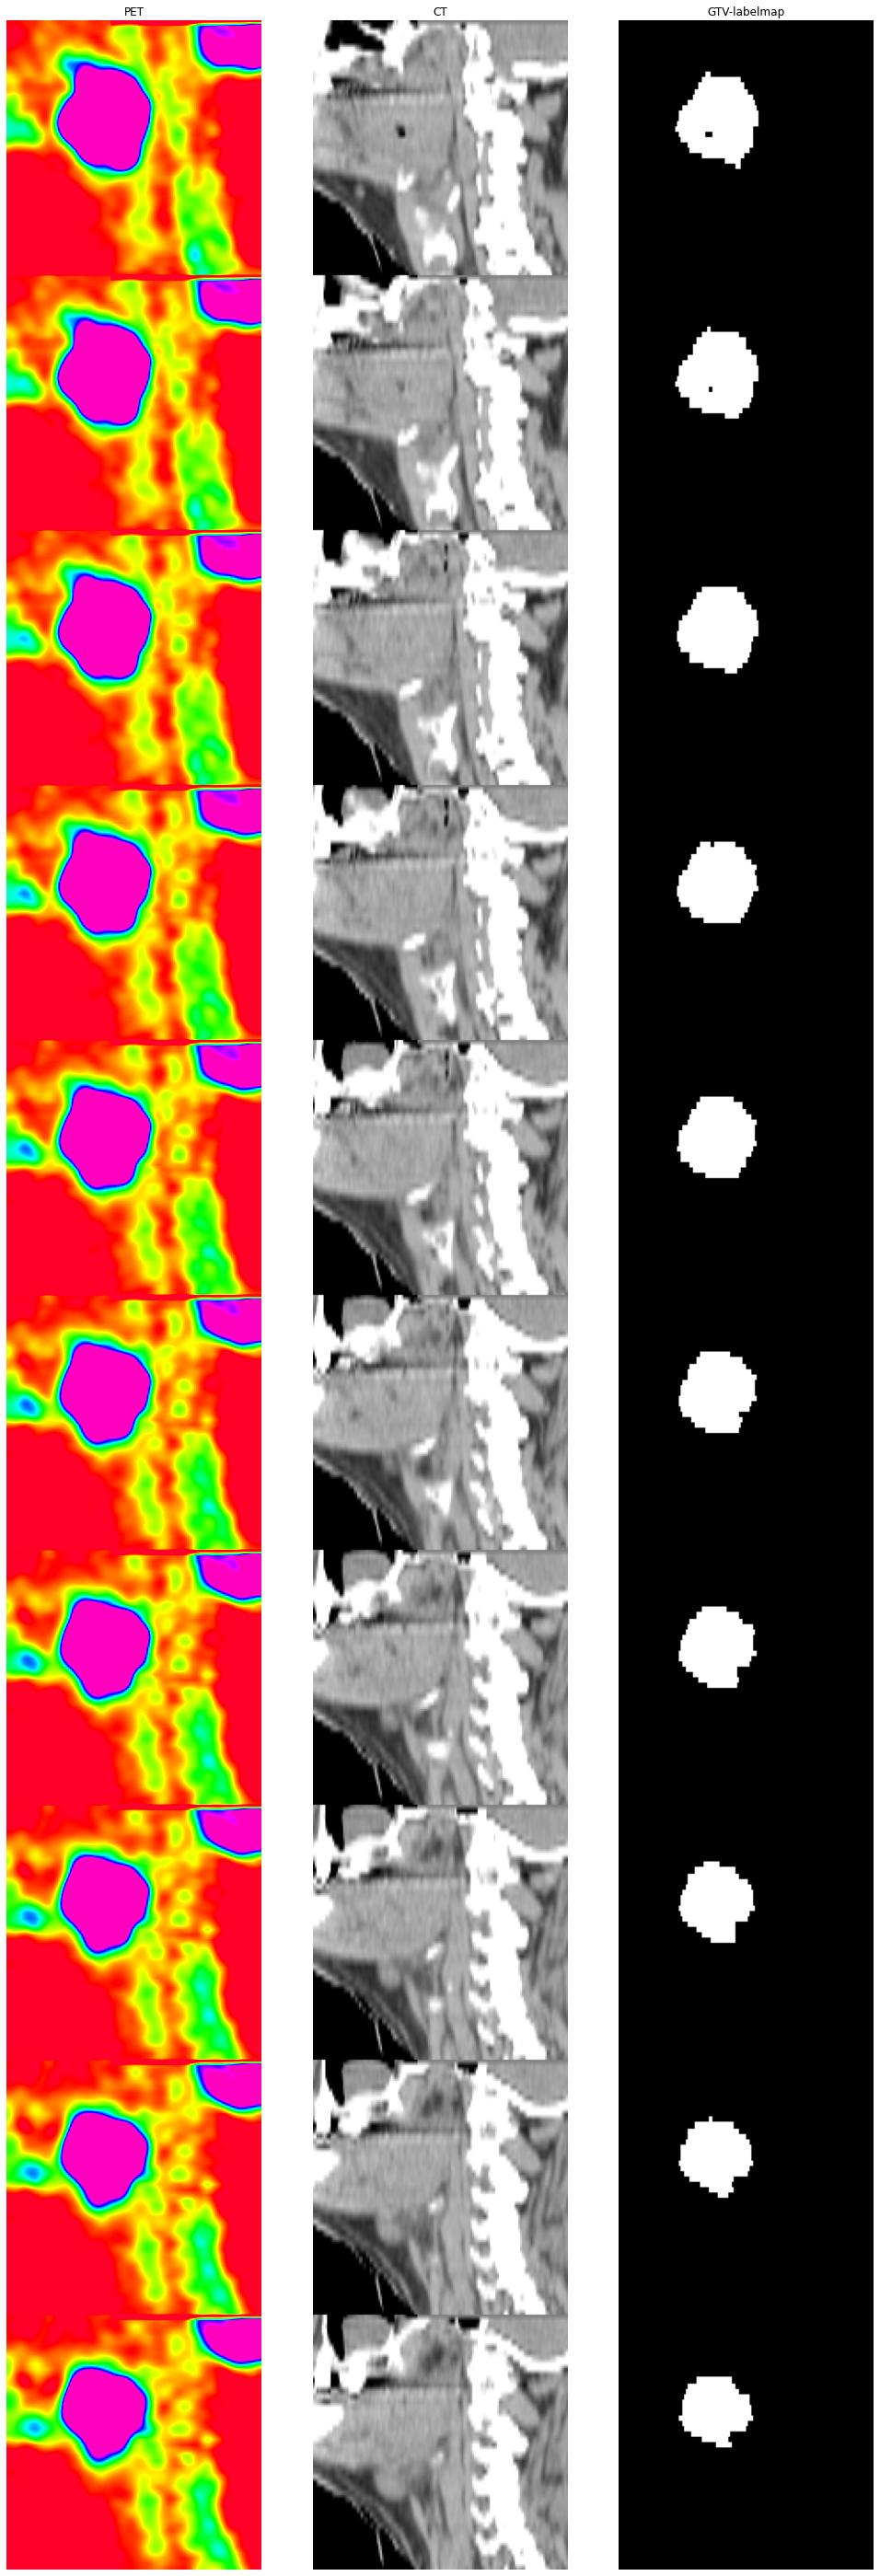

In [4]:
# Display input-output pair slices

viz.multi_image_strips([PET_np, CT_np, GTV_labelmap_np],
                          modalities=['PET', 'CT', 'GTV-labelmap'],
                          idx_range=[90, 100],
                          view='sagittal',
                          subtitles=[])

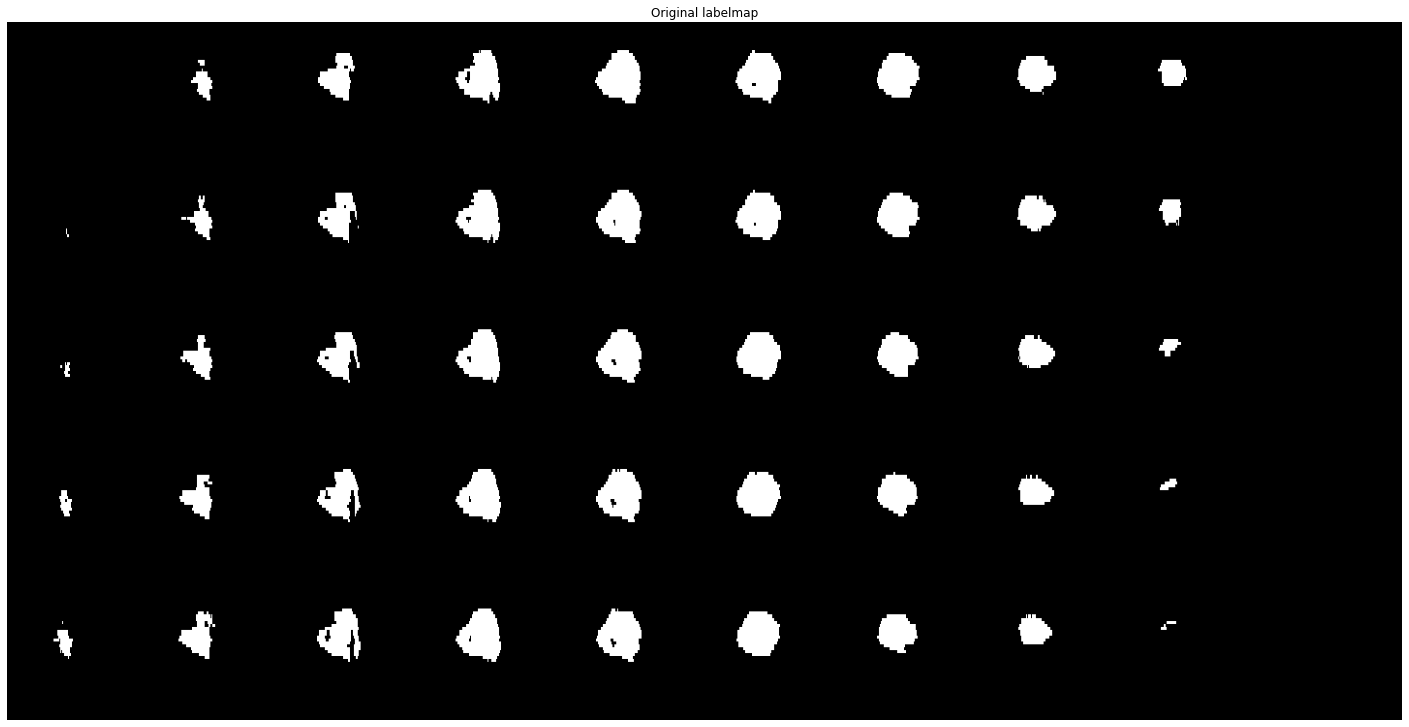

In [5]:
# Display the GTV labelmap

viz.grid(GTV_labelmap_np, idx_range=[65,112], view='sagittal', modality='GTV-labelmap', title='Original labelmap')

## Extract all valid patches from the volume

In [6]:
volume_size = (144,144,48)
patch_size = (128,128,32)
focal_point_stride = (10,10,10)

patch_sampler = PatchSampler3D(patch_size, 
                               sampling='sequential',
                               focal_point_stride=focal_point_stride)

num_valid_patches = get_num_valid_patches(patch_size, volume_size, focal_point_stride)
patches_list = patch_sampler.get_samples(patient_dict, num_patches=num_valid_patches)
print(len(patches_list))

8


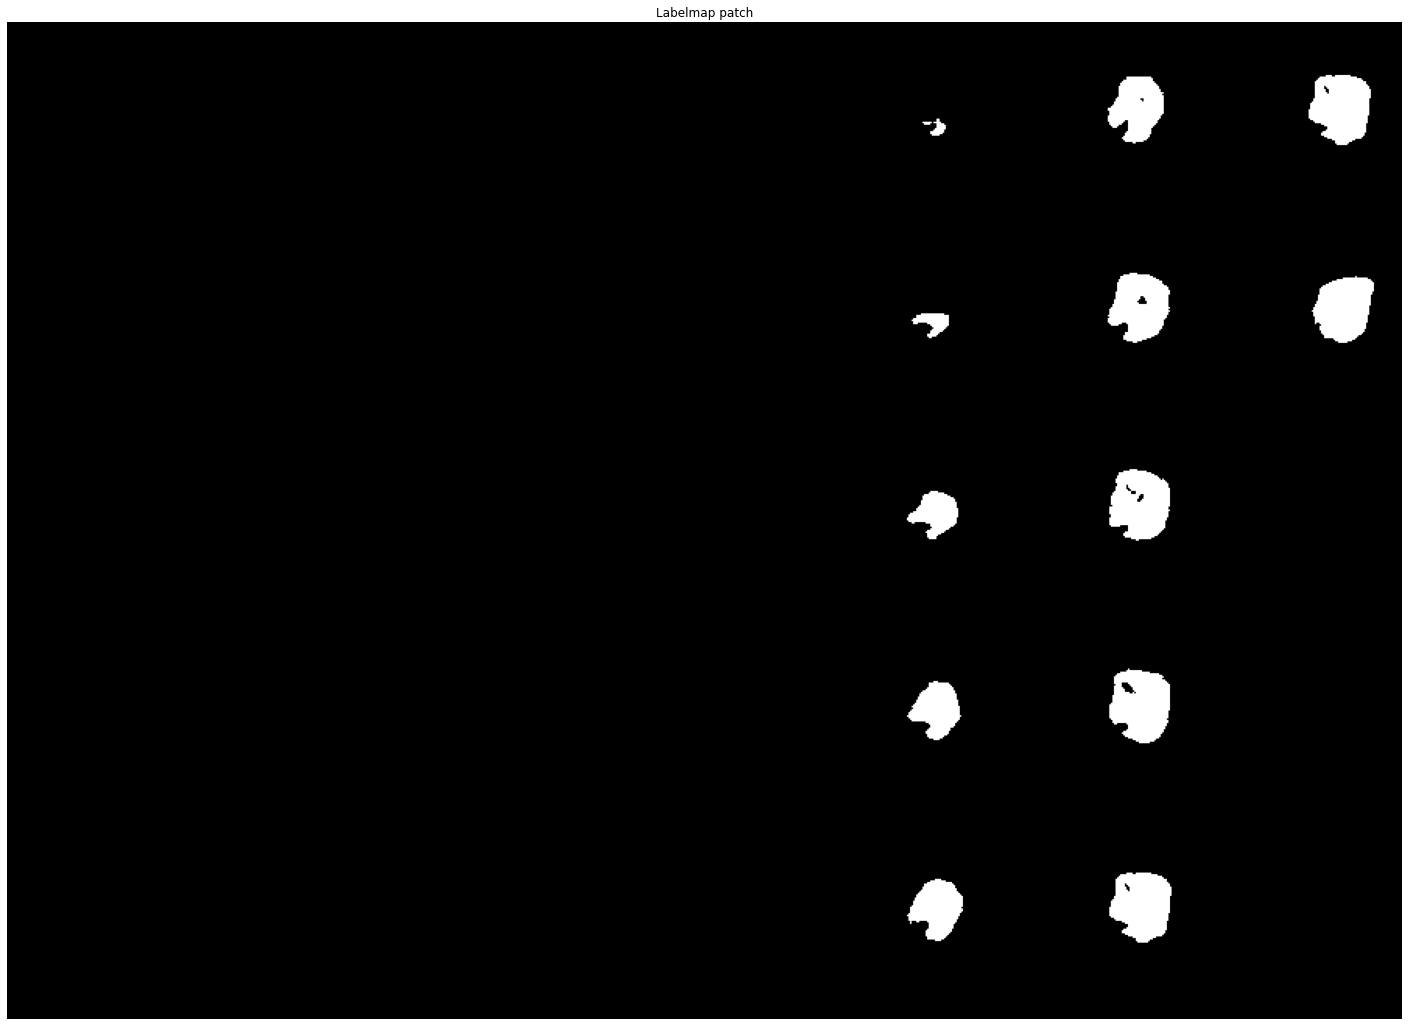

In [7]:
# Display the GTV labelmap patch

GTV_labelmap_patch = patches_list[0]['GTV-labelmap'].permute(2,1,0).numpy().astype(np.int)
viz.grid(GTV_labelmap_patch, idx_range=[0,32], view='axial', modality='GTV-labelmap', title='Labelmap patch')

## Aggregate the patches and compare the volume with the original

In [11]:
patch_aggregator = PatchAggregator3D(patch_size, 
                                     volume_size, 
                                     focal_point_stride, 
                                     overlap_handling=None)

labelmap_patches_list = [patch['GTV-labelmap'].permute(2,1,0).numpy() for patch in patches_list]

recovered_labelmap = patch_aggregator.aggregate(labelmap_patches_list)

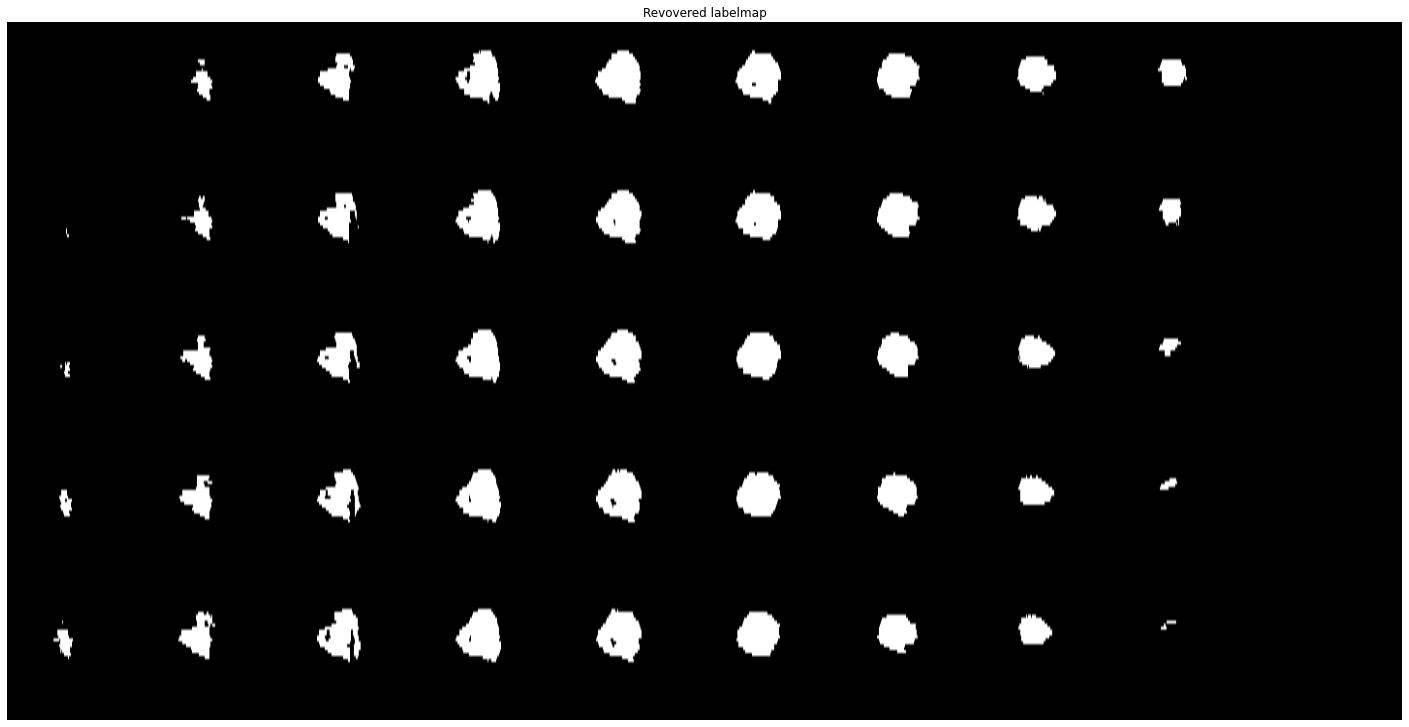

In [12]:
# Display the recovered GTV labelmap

viz.grid(recovered_labelmap, idx_range=[65,112], view='sagittal', modality='GTV-labelmap', title='Revovered labelmap')

In [13]:
# Quantify the similarity

np.sum(recovered_labelmap - GTV_labelmap_np)

0.0